In [2]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.externals import joblib

In [3]:
def get_time(x, c1, c2):     #find the difference between two date columns of dataframe x
    diff =  x[c2] - x[c1]
    days = diff.days
    days_to_hours = days * 24
    diff_btw_two_times = (diff.seconds) / 3600
    overall_hours = days_to_hours + diff_btw_two_times
    return overall_hours

In [5]:
file = 'DataForMLLive.xlsx'
data = pd.ExcelFile(file)
df = data.parse('Order History')

In [6]:
col_names= ['Created Time', 'Biker Assigned Time', 'Biker Accepted Time', 'In Bike TIme','Delivered Time']
df.dropna(subset=col_names, how='any', inplace = True)

In [27]:
timestamp_info = pd.DataFrame(columns=['Created Time', 'Biker Assigned Time', 'Biker Accepted Time', 'In Bike TIme'])
timestamp_info[col_names] = df[col_names].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')
info_taken = pd.DataFrame(columns= ['Hours2assign', 'Hours2deliver', 'BikerID'])
#info_taken['Hours2assign']= df.apply(get_time,c1='Created Time', c2='Biker Assigned Time', axis=1)
#info_taken['Hours2accept']= df.apply(get_time,c1='Biker Assigned Time', c2='Biker Accepted Time', axis=1)
#info_taken['HoursPkgOnBike'] = df.apply(get_time,c1='Biker Accepted Time', c2='In Bike TIme', axis=1)
info_taken['Hours2deliver']= df.apply(get_time, c1='In Bike TIme', c2='Delivered Time', axis=1)
info_taken['BikerID'], levels = pd.factorize(df['Biker'])
info_taken['LocationCode']= df['Location Code']
info_taken['Pending Order By Biker'] = df['Pending Order By Biker']
info_taken['Pending Orders Location Wise']= df['Pending Orders Location Wise'] 

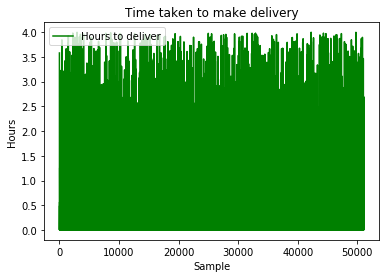

In [28]:
is_strange =  info_taken['Hours2deliver']>4
info_taken= info_taken[~is_strange]
plt.plot(info_taken['Hours2deliver'].values, color= 'green', label= 'Hours to deliver') # p
plt.ylabel('Hours')
plt.xlabel('Sample')
plt.title('Time taken to make delivery')
plt.legend()
plt.show()

In [56]:
df = df [~is_strange]
timestamp_info = df[['Created Time', 'Biker Assigned Time', 'Biker Accepted Time', 'In Bike TIme']].values.astype(int)
location_code = info_taken[['BikerID']].values
X = np.concatenate((timestamp_info, location_code), axis=1)
#X= info_taken[['LocationCode', 'Pending Order By Biker', 'Pending Orders Location Wise', 'BikerID', 'Hours2assign', 'Hours2accept', 'HoursPkgOnBike']].values #, 
Y= np.reshape(info_taken['Hours2deliver'].values, -1)

In [57]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=0.3)

In [66]:
tree_regression_model = tree.DecisionTreeRegressor(min_samples_split=9, max_depth=16, random_state=0)
trained_model = tree_regression_model.fit(X_trn, Y_trn)
joblib.dump(trained_model, 'model4_dt.sav')

['model4_dt.sav']

In [20]:
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
tree_regression_Model = tree.DecisionTreeRegressor(random_state=0)
scoring = make_scorer(r2_score)
parameters={'max_depth': np.arange(6, 25), 'min_samples_split':np.arange(5, 20)}
#cross_validation = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(tree_regression_Model, parameters, cv=5, n_jobs=5, scoring=scoring,verbose=1)

In [21]:
grid_search.fit(X_trn,Y_trn)

Fitting 5 folds for each of 285 candidates, totalling 1425 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:   14.7s
[Parallel(n_jobs=5)]: Done 785 tasks      | elapsed:   44.5s
[Parallel(n_jobs=5)]: Done 1135 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 1425 out of 1425 | elapsed:  1.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params={}, iid=True, n_jobs=5,
       param_grid={'min_samples_split': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'max_depth': array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24])},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(r2_score),
       verbose=1)

In [22]:
print(grid_search.best_params_)
print(grid_search.best_estimator_.feature_importances_)

{'min_samples_split': 9, 'max_depth': 16}
[0.16389205 0.19513993 0.14492952 0.14533144 0.32418227 0.0265248 ]


In [63]:
predict_model = trained_model.predict(X_tst)
#predict_model = grid_search.best_estimator_.predict(X_tst)

In [64]:
print("Mean squared error: "  )
mse= mean_squared_error(Y_tst, predict_model)
print(mse)

print('r2')
print(r2_score(Y_tst, predict_model, sample_weight=None, multioutput='uniform_average'))

Mean squared error: 
0.16683656260917074
r2
0.39575242057832805


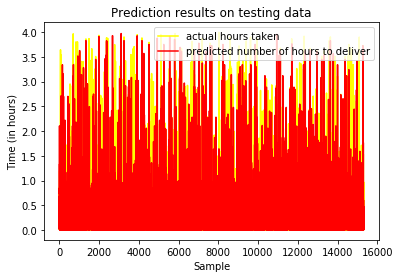

In [65]:
plt.plot(Y_tst, color= 'yellow', label= 'actual hours taken') # p
plt.plot(predict_model, color= 'red', label= 'predicted number of hours to deliver') # p
plt.xlabel('Sample')
plt.ylabel('Time (in hours)')
plt.title('Prediction results on testing data')
plt.legend()
plt.show()